## gensim 패키지에서 제공하는 Word2Vec을 사용하여 영어와 한국어 데이터를 학습해보자.

### 1. 영어 Word2Vec 만들기

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

#### 1) 훈련 데이터 이해하기

훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요하다.  
얻고자 하는 실질적 데이터는 <content> 태그 사이의 내용뿐이다.  
또한 (Laughter), (Appluase)와 같은 배경음등을 제거하자.

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x198ffd78d40>)

#### 2) 훈련 데이터 전처리하기

위 데이터를 위한 전처리 코드는 아래와 같다.

In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
targetXML = open('ted_en-20160408.xml','r',encoding='UTF-8')
target_text = etree.parse(targetXML)    

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [5]:
print(f'총 샘플의 개수 : {len(result)}')

총 샘플의 개수 : 273424


In [6]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### 3) Word2Vec 훈련시키기

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5,workers=4, sg=0)

vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.  
window = 컨텍스트 윈도우 크기  
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)    
workers = 학습을 위한 프로세스 수  
sg = 0은 CBOW, 1은 Skip-gram  

Word2Vec은 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar를 지원한다.  
man과 가장 유사한 단어들은 어떤 단어들일까?  

In [8]:
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8617643117904663), ('guy', 0.8168994784355164), ('lady', 0.7866601347923279), ('boy', 0.7589055299758911), ('soldier', 0.7453145384788513), ('girl', 0.7360820174217224), ('gentleman', 0.734350323677063), ('kid', 0.7027976512908936), ('poet', 0.685711145401001), ('person', 0.652797520160675)]


#### 4) Word2Vec 모델 저장하고 로드하기

공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보자.  
이 모델을 가지고 향후 시각화를 진행한다.

In [10]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 모델 로드

로드한 모델에 대해서 다시 man과 유사한 단어를 출력해보자.

In [11]:
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8617643117904663), ('guy', 0.8168994784355164), ('lady', 0.7866601347923279), ('boy', 0.7589055299758911), ('soldier', 0.7453145384788513), ('girl', 0.7360820174217224), ('gentleman', 0.734350323677063), ('kid', 0.7027976512908936), ('poet', 0.685711145401001), ('person', 0.652797520160675)]


### 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x198bf486f60>)

In [16]:
train_data = pd.read_table('ratings.txt')

In [17]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [19]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


결측값이 존재하므로 결측값이 존재하는 행을 제거한다.

In [20]:
train_data =  train_data.dropna(how = 'any') # NULL값이 존재하는 행 제거
print(train_data.isnull().values.any())

False


결측값이 삭제된 후의 리뷰 개수를 확인한다.

In [21]:
print(len(train_data))

199992


총 199,992개의 리뷰가 존재한다.  
정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행한다.

In [23]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [24]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하자. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행한다.

In [30]:
from tqdm import tqdm

In [31]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거

    tokenized_data.append(stopwords_removed_sentence)

  0%|          | 0/199992 [00:00<?, ?it/s]

100%|██████████| 199992/199992 [09:31<00:00, 350.01it/s]


토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능하다.

리뷰의 최대 길이 :  72
리뷰의 평균 길이 :  10.716703668146726


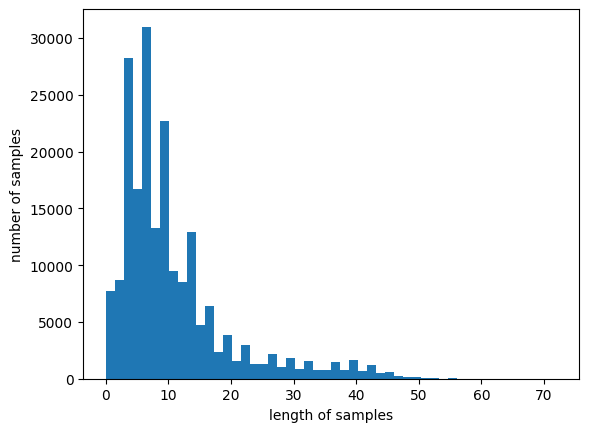

In [32]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 : ', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 : ', sum(map(len,tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec으로 토큰화된 네이버 영화 리뷰 데이터를 학습한다.

In [33]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window=5, min_count=5, workers=4,sg = 0)

학습이 다 되었다면 Word2Vecc 임베딩 행렬의 크기를 확인한다.

In [34]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

총 16477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있다.  
'최민식'과 유사한 단어들을 뽑아보자.  

In [35]:
print(model.wv.most_similar('최민식'))

[('안성기', 0.8546104431152344), ('크리스찬', 0.8345522880554199), ('이민호', 0.8209882974624634), ('양동근', 0.8192102313041687), ('최강희', 0.8171746730804443), ('한석규', 0.8133264183998108), ('김명민', 0.8114588260650635), ('엄정화', 0.8067843914031982), ('정재영', 0.8017433285713196), ('김수현', 0.7971641421318054)]


'히어로'와 유사한 단어들을 뽑아보자.

In [36]:
print(model.wv.most_similar('히어로'))

[('슬래셔', 0.87163907289505), ('무협', 0.8538224697113037), ('호러', 0.8429009914398193), ('느와르', 0.8224890232086182), ('물의', 0.821368396282196), ('물', 0.8188415765762329), ('블록버스터', 0.8072790503501892), ('무비', 0.7951367497444153), ('정통', 0.7945689558982849), ('멜로', 0.7751263380050659)]


### 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 경우가 성능이 더 좋을 때도 많다.  


모델은 google drive에서 다운받았다.

In [41]:
import gensim
import urllib.request

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

모델의 크기가 3,000,000 X 300이다.  
즉, 3백만개의 단어와, 각 단어의 차원은 300개이다.  
파일의 크기가 3기가가 넘는 이유를 계산해보면 아래와 같다.  

- 3,000,000 X 300 X 4bytes/feature ~= 3.35GB

In [42]:
print(word2vec_model.vectors.shape)

(3000000, 300)


사전 훈련된 임베딩을 사용하여 두 단어의 유사도를 계산해보자.

In [43]:
print(word2vec_model.similarity('this','is'))
print(word2vec_model.similarity('post','book'))

0.40797037
0.057204384


단어 'book'의 벡터를 출력해보자.

In [44]:
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

Word2Vec 모델은 자연어처리에서 단어를 밀집 벡터로 만들어주는 임베딩 방법론이지만,  
최근에 들어서 추천 시스템에서도 사용되고 있다.  
적당히 데이터를 나열해주면 Word2Vec이 위치가 근접한 데이터를 유사도가 높은 벡터로 만들어주기 때문이다. 'Item2Vec'을 찾아보자.

### 4. 워드 임베딩 모델로부터 2개의 tsv 파일 생성하기

이제 Word2Vec 모델을 구글이 발표한 임베딩 프로젝터라는 데이터 시각화 도구를 통해 시각화해보자.

In [45]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2025-04-15 17:52:27,912 - word2vec2tensor - INFO - running c:\Users\user\Workspace\gensim-project\.venv\Lib\site-packages\gensim\scripts\word2vec2tensor.py --input eng_w2v --output eng_w2v
2025-04-15 17:52:27,913 - keyedvectors - INFO - loading projection weights from eng_w2v
2025-04-15 17:52:29,438 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (21613, 100) matrix of type float32 from eng_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-04-15T17:52:29.341356', 'gensim': '4.3.3', 'python': '3.12.9 (main, Mar 17 2025, 21:06:20) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}
2025-04-15 17:52:30,502 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2025-04-15 17:52:30,502 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2025-04-15 17:52:30,503 - word2vec2tensor - INFO - finished running word2vec2tensor.py


새로 생긴 'eng_w2v_tensor.tsv', 'eng_w2v_metadata.tsv'가 임베딩 벡터 시각화를 위해 사용할 파일이다.

### 5. 임베딩 프로젝터를 사용하여 시각화하기.

In [1]:
from IPython.display import Image

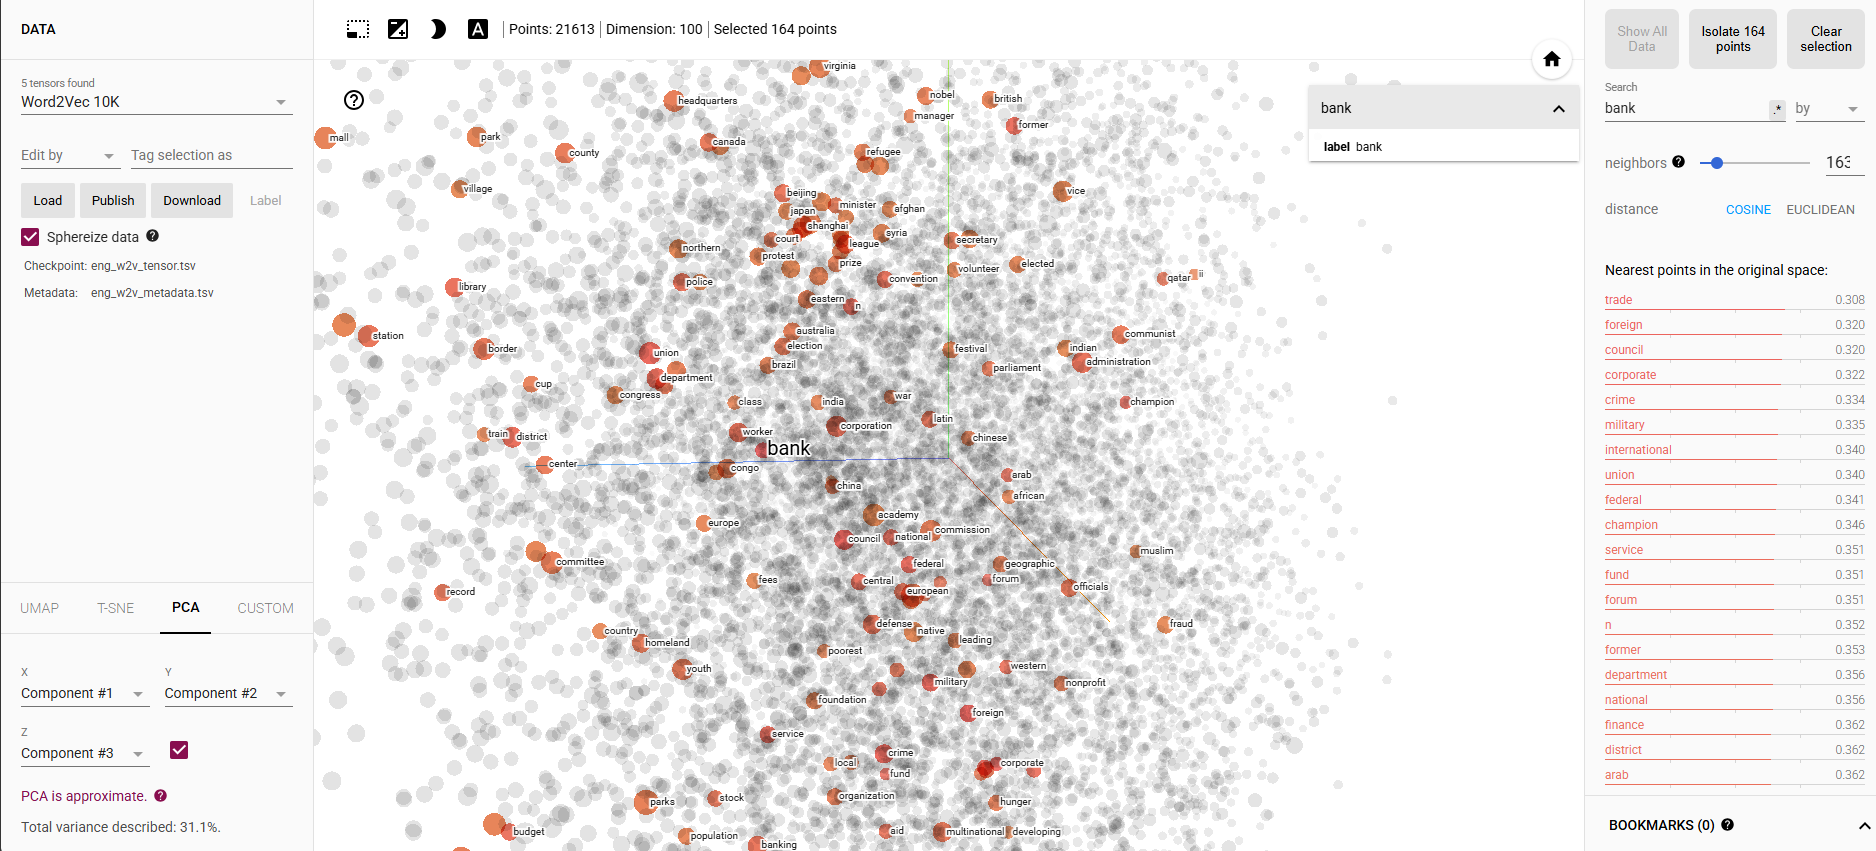

In [3]:
Image("./scr/12-04 Word2Vec Projector Result - bank.png")

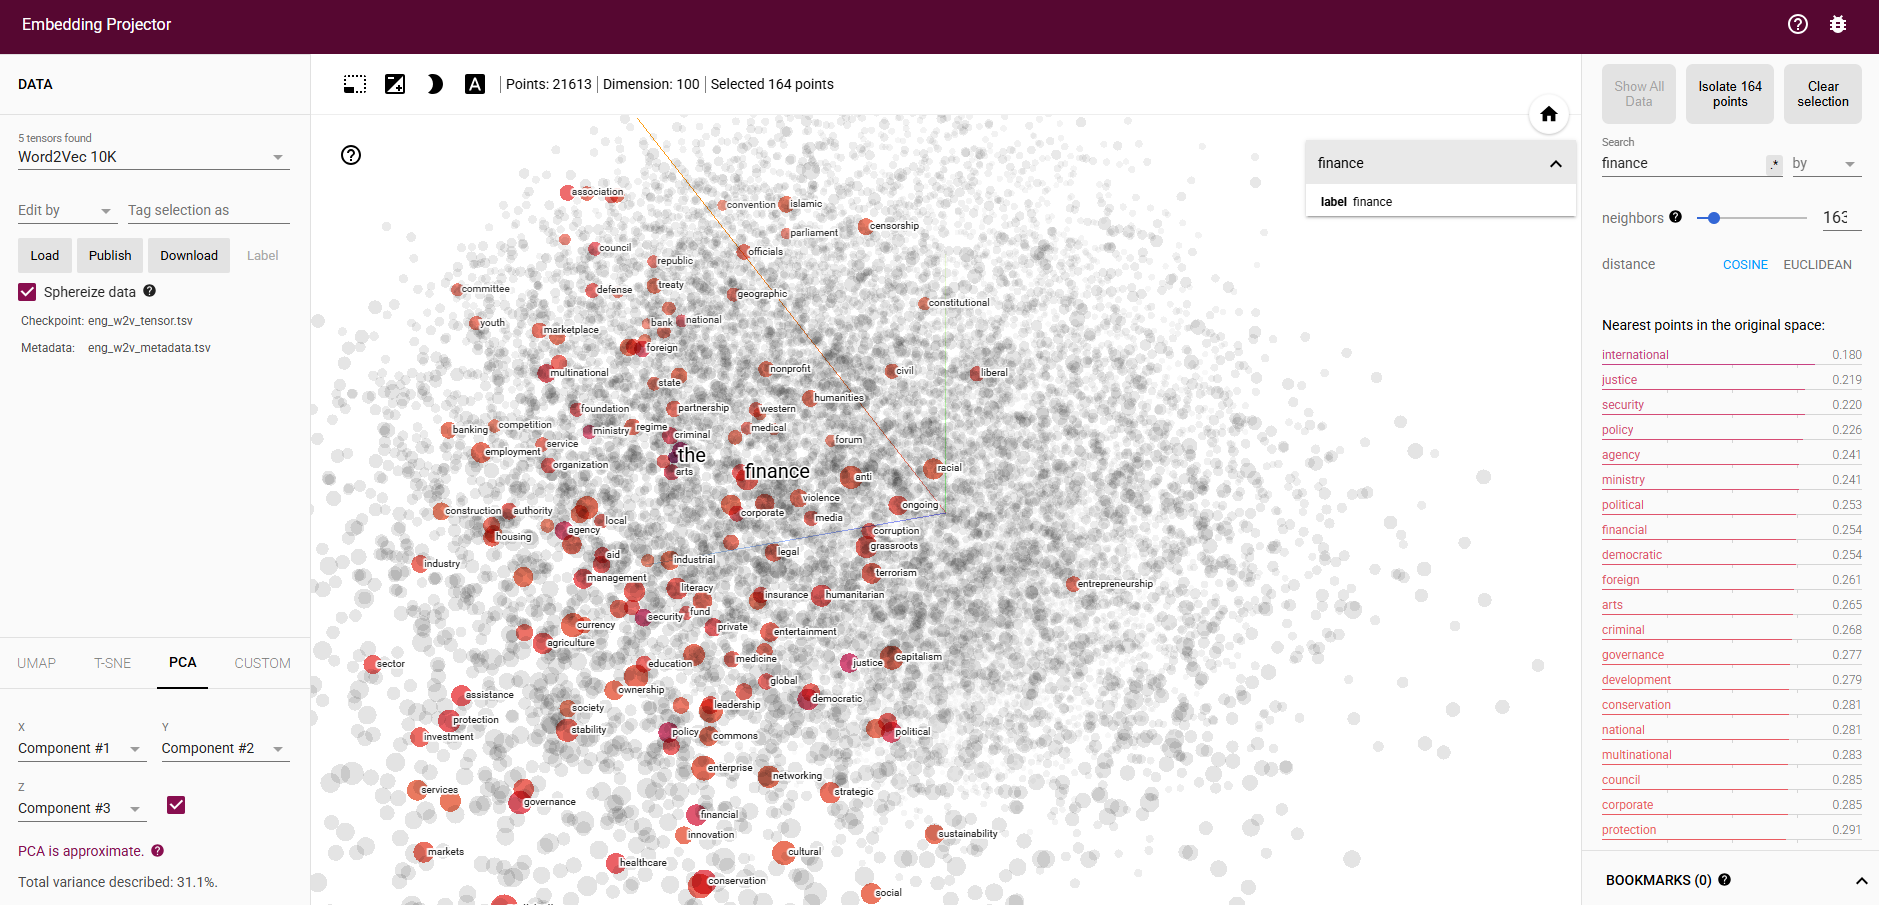

In [4]:
Image("./scr/12-04 Word2Vec Projector Result - finance.png")